In [2]:
#impoort libraries

#data processing and storage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import reduction methods and classifiers
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE

from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#import evaluation metrics and scalers
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

In [2]:
#aux function for dataframe plotting with certain precision
def format(df):
    df = df.rename(columns={'NoneType': 'Raw', 'Unnamed: 0': 'Method'})
    return df.style.format(dict([(col, lambda x: '({:,.4f}, {:,.4f})'.format(*x)) for col in df.columns]))

In [76]:
class trainer():
    '''
        Class trainer: receives the data, dimensionality reduction methods and classifiers to perform classification 
        and evaluation of the methods

        init: 
            data(numpy ndarray): the dataset 
            test_size(float): the percentage of dataset that becomes the test set 
            normalize(bool): if True normalizes the training and test datasets 
        run:
            runs one single classifier on data
            
            classifier(sklearn class): the classifier to be run 
            n_runs(int): number of times to run the classifier
        train:
            runs a list of classifiers using a list of dimensionality reduction methods
            
            classifiers([sklearn class]): a list of classifiers 
            dim_reduction([sklearn class]): a list of dim reduction methods
            n_runs(int): number of times to run the classifiers
    '''
    def __init__(self, data, test_size, normalize=True):
        self.data = data
        self.test_size = test_size
        self.X = self.data[0]
        self.y = self.data[1]
        self.normalize = normalize
        
    def run(self, classifier, n_runs=10):
        acc = []
        X, y = self.X, self.y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y)
        if self.normalize:
            scaler_train, scaler_test = StandardScaler(), StandardScaler()
            X_train = scaler_train.fit_transform(X_train)
            X_test = scaler_test.fit_transform(X_test)

        for i in range(n_runs):        
            if classifier.__class__.__name__ not in ("KMeans", "GaussianMixture"):
                classifier.fit(X_train, y_train)
                acc.append(classifier.score(X_test, y_test))
                
            else:
                if classifier.__class__.__name__ == "GaussianMixture":
                    classifier.fit(X)
                    probs = classifier.predict_proba(X)
                    class_indexes = np.argmax(probs, axis=1)
                    acc.append(adjusted_rand_score(y, class_indexes))
                if classifier.__class__.__name__ == "KMeans":
                    labels = classifier.fit_predict(X)
                    acc.append(adjusted_rand_score(y, labels))
        return np.mean(acc), np.std(acc)
    
    def train(self, classifiers, dim_reduction, n_runs):
    
        rows = [clf.__class__.__name__ for clf in classifiers]
        cols = [dr.__class__.__name__ for dr in dim_reduction]
        df = pd.DataFrame(index = rows, columns=cols)
        
        for dr in dim_reduction:
             
            print(f'Reducing dimensionality using {dr.__class__.__name__}...')
            if dr:
                if dr.__class__.__name__ == "LinearDiscriminantAnalysis":
                    self.X = dr.fit_transform(self.X, self.y)
                else:
                    self.X = dr.fit_transform(self.X)   
            print('Done!')
            for clf in classifiers:
                print(f'Training {clf.__class__.__name__}...')
                df.loc[clf.__class__.__name__, dr.__class__.__name__] = self.run(clf, n_runs=n_runs)
                print('Done!')                   
            self.X = self.data[0]
        return df

In [89]:
data1 = load_digits(return_X_y=True)
data2 = fetch_openml(name='mfeat-pixel', version=1, return_X_y=True, as_frame=False)

#the script uses the class name in the dataframe
#to avoid two SVC rows, create two new classes
class SVC_linear(SVC):
    def __init__(self):
        super().__init__(kernel='linear')
        
class SVC_rbf(SVC):
    def __init__(self):
        super().__init__(kernel='rbf')

#list of dimensionality reduction methods
dim_reduction = [
    PCA(n_components=20, svd_solver='full'),
    LinearDiscriminantAnalysis(n_components=9),
    KernelPCA(n_components=20, kernel='poly'),
    Isomap(n_components=20),
    LocallyLinearEmbedding(n_components=20),
    SpectralEmbedding(n_components=20),
    TSNE(n_components=20, learning_rate='auto', init='random', perplexity=3, method='exact'),
    None
    ]
#list of classification methods
classifiers = [
    Perceptron(tol=1e-3, random_state=0),
    RidgeClassifier(alpha=0.),
    MLPClassifier(random_state=1, max_iter=500),
    KNeighborsClassifier(n_neighbors=7),
    NearestCentroid(),
    QuadraticDiscriminantAnalysis(),
    SVC_linear(),
    SVC_rbf(),
    KMeans(n_clusters=10),
    GaussianMixture(n_components=10)
    ]

In [91]:
# run dataset digits
trainer1 = trainer(data1, 0.5)
data_1_res = trainer1.train(classifiers, dim_reduction, 20)

Reducing dimensionality using PCA...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using LinearDiscriminantAnalysis...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using KernelPCA...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training Quadr

/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using LocallyLinearEmbedding...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...


/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site

Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using SpectralEmbedding...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using TSNE...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using NoneType...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Train

/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site

Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!


In [92]:
# run dataset mfeat-pixel
trainer2 = trainer(data2, 0.5)
data_2_res = trainer2.train(classifiers, dim_reduction, 20)

Reducing dimensionality using PCA...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using LinearDiscriminantAnalysis...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using KernelPCA...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training Quadr

/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site

Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using SpectralEmbedding...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using TSNE...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training MLPClassifier...
Done!
Training KNeighborsClassifier...
Done!
Training NearestCentroid...
Done!
Training QuadraticDiscriminantAnalysis...
Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!
Reducing dimensionality using NoneType...
Done!
Training Perceptron...
Done!
Training RidgeClassifier...
Done!
Training

/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site

Done!
Training SVC_linear...
Done!
Training SVC_rbf...
Done!
Training KMeans...
Done!
Training GaussianMixture...
Done!


In [94]:
#print results 1
format(data_1_res)

,PCA,LinearDiscriminantAnalysis,KernelPCA,Isomap,LocallyLinearEmbedding,SpectralEmbedding,TSNE,Raw
Perceptron,"(0.9277, 0.0000)","(0.9477, 0.0000)","(0.9344, 0.0000)","(0.9755, 0.0000)","(0.9755, 0.0000)","(0.9244, 0.0000)","(0.8076, 0.0000)","(0.9299, 0.0000)"
RidgeClassifier,"(0.9043, 0.0000)","(0.9577, 0.0000)","(0.9288, 0.0000)","(0.9455, 0.0000)","(0.9766, 0.0000)","(0.9277, 0.0000)","(0.8487, 0.0000)","(0.1023, 0.0000)"
MLPClassifier,"(0.9611, 0.0000)","(0.9677, 0.0000)","(0.9711, 0.0000)","(0.9867, 0.0000)","(0.9844, 0.0000)","(0.9633, 0.0000)","(0.9811, 0.0000)","(0.9733, 0.0000)"
KNeighborsClassifier,"(0.9744, 0.0000)","(0.9633, 0.0000)","(0.9677, 0.0000)","(0.9855, 0.0000)","(0.9811, 0.0000)","(0.9555, 0.0000)","(0.9766, 0.0000)","(0.9689, 0.0000)"
NearestCentroid,"(0.9221, 0.0000)","(0.9466, 0.0000)","(0.9177, 0.0000)","(0.9588, 0.0000)","(0.9822, 0.0000)","(0.9199, 0.0000)","(0.8165, 0.0000)","(0.8765, 0.0000)"
QuadraticDiscriminantAnalysis,"(0.9778, 0.0000)","(0.9611, 0.0000)","(0.9833, 0.0000)","(0.9789, 0.0000)","(0.1012, 0.0000)","(0.9333, 0.0000)","(0.9822, 0.0000)","(0.1112, 0.0000)"
SVC_linear,"(0.9644, 0.0000)","(0.9666, 0.0000)","(0.9577, 0.0000)","(0.9711, 0.0000)","(0.9878, 0.0000)","(0.9444, 0.0000)","(0.9566, 0.0000)","(0.9822, 0.0000)"
SVC_rbf,"(0.9911, 0.0000)","(0.9755, 0.0000)","(0.9867, 0.0000)","(0.9878, 0.0000)","(0.9878, 0.0000)","(0.9611, 0.0000)","(0.9789, 0.0000)","(0.9844, 0.0000)"
KMeans,"(0.6367, 0.0567)","(0.8898, 0.0483)","(0.6153, 0.0435)","(0.7690, 0.0503)","(0.4640, 0.0715)","(0.5966, 0.0616)","(0.3396, 0.0295)","(0.6173, 0.0440)"
GaussianMixture,"(0.7169, 0.0378)","(0.8909, 0.0571)","(0.7194, 0.0459)","(0.7710, 0.0541)","(0.7322, 0.0633)","(0.6714, 0.0358)","(0.6805, 0.0690)","(0.6501, 0.0563)"


In [93]:
#print results 2
format(data_2_res)

,PCA,LinearDiscriminantAnalysis,KernelPCA,Isomap,LocallyLinearEmbedding,SpectralEmbedding,TSNE,Raw
Perceptron,"(0.9360, 0.0000)","(0.9630, 0.0000)","(0.9420, 0.0000)","(0.9370, 0.0000)","(0.8980, 0.0000)","(0.9310, 0.0000)","(0.8030, 0.0000)","(0.9110, 0.0000)"
RidgeClassifier,"(0.9180, 0.0000)","(0.9680, 0.0000)","(0.9420, 0.0000)","(0.9540, 0.0000)","(0.9660, 0.0000)","(0.9210, 0.0000)","(0.8470, 0.0000)","(0.9150, 0.0000)"
MLPClassifier,"(0.9570, 0.0000)","(0.9700, 0.0000)","(0.9580, 0.0000)","(0.9620, 0.0000)","(0.9770, 0.0000)","(0.9480, 0.0000)","(0.9670, 0.0000)","(0.9800, 0.0000)"
KNeighborsClassifier,"(0.9540, 0.0000)","(0.9790, 0.0000)","(0.9670, 0.0000)","(0.9670, 0.0000)","(0.9770, 0.0000)","(0.9480, 0.0000)","(0.9770, 0.0000)","(0.9740, 0.0000)"
NearestCentroid,"(0.9250, 0.0000)","(0.9660, 0.0000)","(0.9340, 0.0000)","(0.9600, 0.0000)","(0.9670, 0.0000)","(0.9320, 0.0000)","(0.8090, 0.0000)","(0.9320, 0.0000)"
QuadraticDiscriminantAnalysis,"(0.9640, 0.0000)","(0.9740, 0.0000)","(0.9640, 0.0000)","(0.9660, 0.0000)","(0.1090, 0.0000)","(0.8420, 0.0000)","(0.9680, 0.0000)","(0.2870, 0.0000)"
SVC_linear,"(0.9540, 0.0000)","(0.9760, 0.0000)","(0.9560, 0.0000)","(0.9570, 0.0000)","(0.9720, 0.0000)","(0.9530, 0.0000)","(0.9300, 0.0000)","(0.9730, 0.0000)"
SVC_rbf,"(0.9780, 0.0000)","(0.9790, 0.0000)","(0.9680, 0.0000)","(0.9730, 0.0000)","(0.9740, 0.0000)","(0.9540, 0.0000)","(0.9710, 0.0000)","(0.9750, 0.0000)"
KMeans,"(0.6510, 0.0440)","(0.9334, 0.0419)","(0.6472, 0.0576)","(0.7994, 0.0686)","(0.6283, 0.0974)","(0.5538, 0.0763)","(0.3378, 0.0272)","(0.6222, 0.0721)"
GaussianMixture,"(0.6654, 0.0592)","(0.9195, 0.0457)","(0.6900, 0.0703)","(0.7813, 0.0646)","(0.7756, 0.0808)","(0.5888, 0.0405)","(0.5995, 0.0520)","(0.5877, 0.0554)"


In [95]:
#save results to csv
data_1_res.to_csv("./digits_results.csv")
data_2_res.to_csv("./mfeat-pixel.csv")

In [60]:
#get col and row average
import ast

def get_avg(df):
    res_dict_col = {}
    res_dict_row = {}
    for col in df.columns:
        aux = np.stack(df[col].apply(lambda x: ast.literal_eval(str(x))).to_numpy())
        res_dict_col[col] = aux[:,0].mean()
    for row in df.index:
        aux = np.stack(df.loc[row].apply(lambda x: ast.literal_eval(str(x))).to_numpy())
        res_dict_row[row] = aux[:,0].mean()
    
    return sorted(res_dict_col.items(), key=lambda item: item[1], reverse=True), sorted(res_dict_row.items(), key=lambda item: item[1], reverse=True)

In [101]:
get_avg(df1)

([('LinearDiscriminantAnalysis', 0.9467001980838102),
  ('Isomap', 0.9329749465116326),
  ('KernelPCA', 0.8982048158394885),
  ('PCA', 0.8976503176140419),
  ('SpectralEmbedding', 0.8797523351869632),
  ('TSNE', 0.8368302800857),
  ('LocallyLinearEmbedding', 0.8172889177125005),
  ('NoneType', 0.7196221308524592)],
 [('SVC_rbf', 0.9816462736373749),
  ('MLPClassifier', 0.9735817575083426),
  ('KNeighborsClassifier', 0.9716351501668521),
  ('SVC_linear', 0.9663515016685207),
  ('Perceptron', 0.9278364849833147),
  ('NearestCentroid', 0.917547274749722),
  ('RidgeClassifier', 0.8239710789766408),
  ('QuadraticDiscriminantAnalysis', 0.7536151279199109),
  ('GaussianMixture', 0.7290517146144453),
  ('KMeans', 0.616043563133121)])

In [98]:
get_avg(df2)

([('LinearDiscriminantAnalysis', 0.9627952818199923),
  ('Isomap', 0.9256761983682132),
  ('KernelPCA', 0.8968143352209834),
  ('PCA', 0.8902423348516937),
  ('SpectralEmbedding', 0.8571630728984196),
  ('LocallyLinearEmbedding', 0.8243868783926661),
  ('TSNE', 0.8209328914757371),
  ('NoneType', 0.8156936017467677)],
 [('SVC_rbf', 0.9715),
  ('KNeighborsClassifier', 0.967875),
  ('MLPClassifier', 0.9648749999999999),
  ('SVC_linear', 0.9588749999999999),
  ('RidgeClassifier', 0.928875),
  ('NearestCentroid', 0.9281250000000001),
  ('Perceptron', 0.9151250000000002),
  ('QuadraticDiscriminantAnalysis', 0.75925),
  ('GaussianMixture', 0.7009804390164536),
  ('KMeans', 0.6466503044516381)])

In [165]:
#plot reductions
def visualize_reduction(data, reduction_method):
    X, y = data
    X_r = []
    for dr in reduction_method:
        if dr.__class__.__name__ == 'LinearDiscriminantAnalysis':
            X_r.append(dr.fit_transform(X,y))
        else:
            X_r.append(dr.fit_transform(X))        
    fig, axs = plt.subplots(len(X_r)//2 + 1, 2, figsize=(8,12))
    #print(list(zip(X_r,*axs)))
    for xr,ax,dr in zip(X_r,axs.flat,reduction_method):
        im = ax.scatter(xr[:,0], xr[:,1], c=list(map(int,y)), cmap='Dark2')
        ax.axis('off')
        ax.set_title(dr.__class__.__name__)
    plt.tight_layout()
    fig.delaxes(axs.flat[-1])
    fig.colorbar(im, ax=axs.ravel().tolist())


In [168]:
dim_reduction = [
    PCA(n_components=2, svd_solver='full'),
    LinearDiscriminantAnalysis(n_components=2),
    KernelPCA(n_components=2, kernel='poly'),
    Isomap(n_components=2),
    LocallyLinearEmbedding(n_components=2),
    SpectralEmbedding(n_components=2),
    TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, method='exact'),
]

/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/hiroshi/anaconda3/envs/python_3.10/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


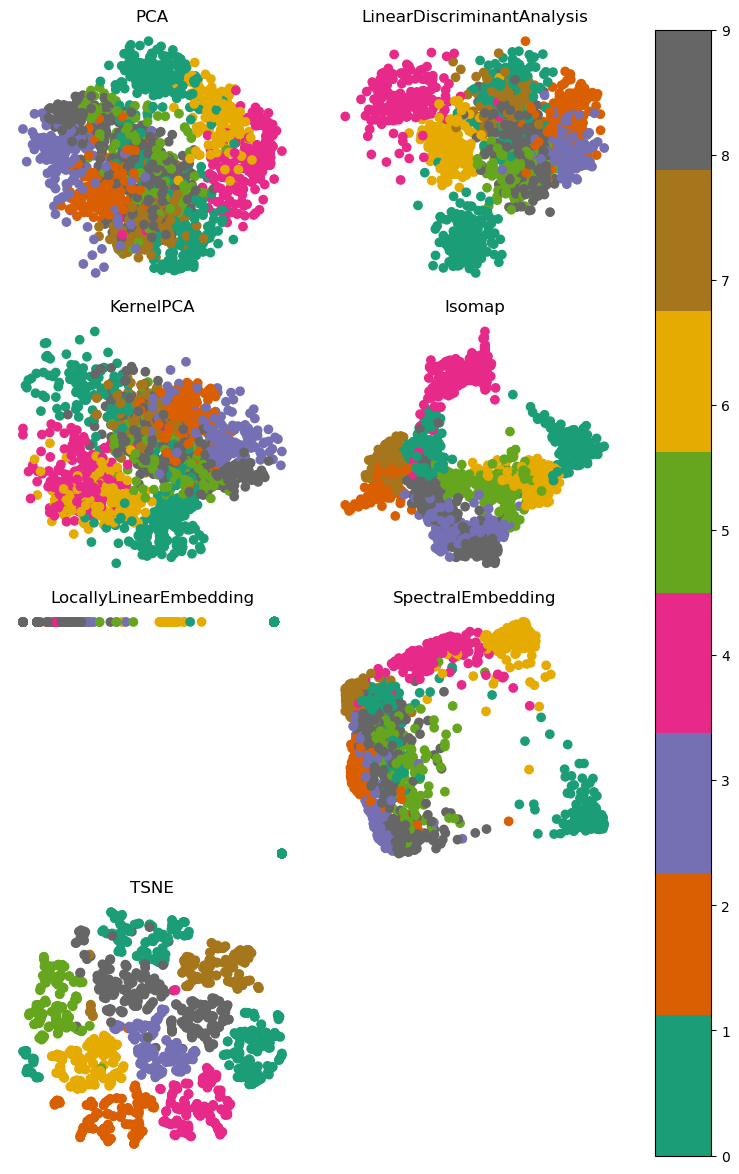

In [169]:
visualize_reduction(data1, dim_reduction)

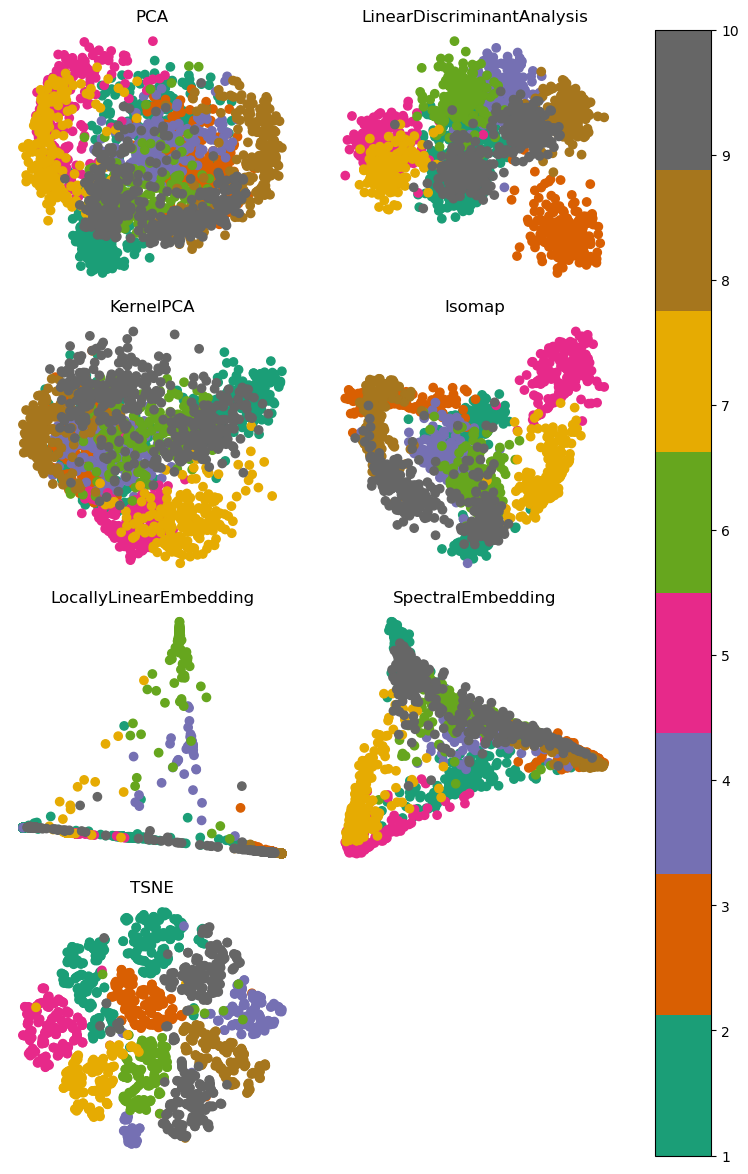

In [170]:
visualize_reduction(data2, dim_reduction)